# Static Investment 

Rodrigo Hernández Mota 

In [50]:
# Import libraries
% matplotlib inline

import datetime as dt
import numpy as np
import pandas as pd
import time 

from cvxopt import matrix, solvers  
from trading_session import * 
from financial_series.everything import * 
from financial_series.stationary_test import adf
from metallic_blue_lizard.neural_net import adaline

## Download Prices 

In [4]:
# Determine time-range
_from, _to = '2016/01/01', dt.datetime.strftime(dt.datetime.now(),'%Y/%m/%d')

In [5]:
# Get available stocks

# create instance of TradingSession object 
ts = TradingSession(user='sd8892',pw='Mexico0r',alias='Trading Session')

# query available stocks 
available_stocks = ts.getOptions()
print(available_stocks)

# close session
ts.close()


['AC', 'ALFA.A', 'ALSEA', 'AMX.L', 'ASUR.B', 'BIMBO.A', 'CEMEX.CPO', 'ELEKTRA', 'FEMSA.UBD', 'GAP.B', 'GCARSO.A1', 'GENTERA', 'GFINBUR.O', 'GFNORTE.O', 'GFREGIO.O', 'GMEXICO.B', 'GRUMA.B', 'ICA', 'ICH.B', 'IENOVA', 'KIMBER.A', 'KOF.L', 'LAB.B', 'LACOMER.UBC', 'LALA.B', 'LIVEPOL.C1', 'MEXCHEM', 'NAFTRAC.ISHRS', 'NEMAK.A', 'OHLMEX', 'OMA.B', 'PENOLES', 'PINFRA', 'SANMEX.B', 'SIMEC.B', 'TLEVISA.CPO', 'WALMEX']


In [6]:
available_stocks = [i for i in available_stocks if i != 'NAFTRAC.ISHRS']

In [7]:
# Create list of Stock instances.
obj = list(map(lambda x: 
               Stock(units='MXN',stock_name=yahoo_dict[x],t0=_from,tf=_to), 
               available_stocks))

# Save information in stocks dictionary 
stocks = {}
total_errors = 0
for i,j in zip(obj,available_stocks):
    print('\n- Downloading data: {}'.format(i.name()),end=' ')
    try:
        i.fill()
    except:
        print('\n\t>> Error: cannot download data: {}\n'.format(i.name()))
        total_errors += 1
        continue
    stocks[j] = i
    print('Done.')

# print total of unavailable stock information 
del obj
print('\nTotal Errors: {}'.format(total_errors))


- Downloading data: AC.MX : (MXN) Done.

- Downloading data: ALFAA.MX : (MXN) Done.

- Downloading data: ALSEA.MX : (MXN) Done.

- Downloading data: AMXL.MX : (MXN) Done.

- Downloading data: ASURB.MX : (MXN) Done.

- Downloading data: BIMBOA.MX : (MXN) Done.

- Downloading data: CEMEXCPO.MX : (MXN) Done.

- Downloading data: ELEKTRA.MX : (MXN) Done.

- Downloading data: FEMSAUBD.MX : (MXN) 
	>> Error: cannot download data: FEMSAUBD.MX : (MXN)


- Downloading data: GAPB.MX : (MXN) Done.

- Downloading data: GCARSOA1.MX : (MXN) Done.

- Downloading data: GENTERA.MX : (MXN) Done.

- Downloading data: GFINBURO.MX : (MXN) Done.

- Downloading data: GFNORTEO.MX : (MXN) Done.

- Downloading data: GFREGIOO.MX : (MXN) Done.

- Downloading data: GMEXICOB.MX : (MXN) Done.

- Downloading data: GRUMAB.MX : (MXN) Done.

- Downloading data: ICA.MX : (MXN) Done.

- Downloading data: ICHB.MX : (MXN) Done.

- Downloading data: IENOVA.MX : (MXN) Done.

- Downloading data: KIMBERA.MX : (MXN) Done.

- Do

## Match dates for prices and returns 

In [8]:
def getAllPrices(dct):
    
    # get first item 
    first = list(dct.keys())[0]
    price = {first:dct[first].prices.Adj_close}
    price = pd.DataFrame(price, index=price[first].index)
    
    # get other items 
    for k in dct:
        
        if k in [first]:
            continue
        
        # calculate temporal dataframe 
        temp = {k:dct[k].prices.Adj_close}
        temp = pd.DataFrame(temp, index=temp[k].index)
        
        # concatenate
        price = pd.concat([price, temp],axis=1).dropna()
        
    return price

def getAllReturns(dct, _type='log'):
    
    prices = getAllPrices(dct)
    returns = {}
    for i in prices:
        temp = prices[i].values
        if _type == 'log':
            returns[i] = np.log(temp[1:] / temp[:-1])
        if _type == 'nor' or _type == 'simple' or _type == 'sim':
            returns[i] = temp[1:] / temp[:-1] - 1
    return pd.DataFrame(returns, index=prices.index[1:])

In [9]:
prices = getAllPrices(stocks)
returns = getAllReturns(stocks, _type='log')

In [10]:
prices.head()

,NEMAK.A,CEMEX.CPO,LALA.B,AC,KIMBER.A,ASUR.B,ICH.B,GFINBUR.O,ALSEA,OMA.B,...,IENOVA,GCARSO.A1,MEXCHEM,WALMEX,GMEXICO.B,GAP.B,SANMEX.B,KOF.L,SIMEC.B,ALFA.A
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-01,23.24,9.06731,39.35,103.04,37.31225,239.17,55.67,30.68771,59.19761,80.73,...,72.22,70.19526,38.03113,42.74808,36.34171,145.83,27.79305,121.07,38.52,34.023
2016-01-04,23.16,8.76923,39.18,100.49,36.19390,233.68,54.93,29.55295,58.28764,78.96,...,72.86,69.05798,38.23857,42.10917,35.27487,142.50,27.06721,117.54,38.02,33.663
2016-01-05,22.75,8.64423,39.42,99.54,35.94435,228.52,54.70,29.20759,58.76241,78.77,...,71.36,69.91835,38.10028,41.93224,36.00585,141.88,27.30609,116.10,37.58,33.913
2016-01-06,22.57,8.62500,39.43,100.90,36.16617,227.48,53.97,28.80303,58.54481,79.21,...,70.83,69.69090,37.59649,41.65701,35.13657,140.98,27.26016,117.57,37.50,33.574
2016-01-07,21.98,7.94231,38.61,99.58,36.19390,226.25,52.58,28.14191,56.30945,78.15,...,72.19,67.39655,36.01598,39.30779,34.58339,135.54,26.18518,117.45,36.66,31.389


In [11]:
returns.head()

,AC,ALFA.A,ALSEA,AMX.L,ASUR.B,BIMBO.A,CEMEX.CPO,ELEKTRA,GAP.B,GCARSO.A1,...,LALA.B,MEXCHEM,NEMAK.A,OHLMEX,OMA.B,PINFRA,SANMEX.B,SIMEC.B,TLEVISA.CPO,WALMEX
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-04,-0.025059,-0.010637,-0.015491,-0.007453,-0.023222,-0.020445,-0.033427,-0.028417,-0.023100,-0.016334,...,-0.004330,0.005440,-0.003448,-0.001696,-0.022169,0.000986,-0.026463,-0.013065,-0.018357,-0.015059
2016-01-05,-0.009499,0.007399,0.008112,-0.005000,-0.022329,0.016521,-0.014357,-0.030657,-0.004360,0.012382,...,0.006107,-0.003623,-0.017862,0.007892,-0.002409,0.003100,0.008787,-0.011640,-0.007940,-0.004211
2016-01-06,0.013570,-0.010046,-0.003710,-0.019402,-0.004561,0.004359,-0.002227,-0.041837,-0.006364,-0.003258,...,0.000254,-0.013311,-0.007944,-0.005066,0.005570,-0.018643,-0.001683,-0.002131,-0.016295,-0.006585
2016-01-07,-0.013169,-0.067294,-0.038930,-0.034665,-0.005422,0.004560,-0.082461,-0.025130,-0.039351,-0.033476,...,-0.021016,-0.042948,-0.026489,-0.023410,-0.013472,-0.015386,-0.040233,-0.022655,-0.002000,-0.058047
2016-01-08,-0.000904,-0.020893,-0.003343,-0.037741,-0.004163,0.008195,-0.061155,-0.013723,0.016972,-0.000587,...,0.009537,-0.001373,0.046665,0.000578,-0.016254,-0.019607,-0.008810,0.003812,0.015123,0.025674


## Determine portfolio via Markowitz and quadratic programming 

In [12]:
def getSolutionMkw(returns,alpha_1=1,alpha_2=1):
    """
    Returns an optim.porfolio f
    """
    solvers.options['show_progress'] = False
    
    # number of variables
    r = returns.shape[1]
    
    # mean and covariance
    _mean = returns.mean()
    _cov  = returns.cov()

    # parameters
    P = matrix(alpha_2*_cov.values)
    Q = matrix(-alpha_1*_mean.values)
    G = matrix(-1.*np.identity(r))
    h = matrix([0. for i in range(r)])
    A = matrix([1. for i in range(r)], (1,r))
    b = matrix(1.)
    
    # get solution
    sol = solvers.qp(P,Q,G,h,A,b)
    
    return np.asmatrix([i for i in sol['x']])

In [13]:
alpha2range=np.arange(1,500)
def iterativeSelectionProcess(returns,w_opt_list=None,tolerance=0.05,alpha2range=np.arange(1,500)):
    
    if w_opt_list is None: 
        w_opt_list =  [getSolutionMkw(returns,alpha_2=a2) for a2 in alpha2range]
    
    save_sum = []
    for i in w_opt_list:
        temp = [i[0,j] for j in range(np.shape(i)[1])]
        save_sum = (save_sum + np.array(temp)) if len(save_sum)!=0 else np.array(temp)

    selection = pd.DataFrame(save_sum).apply(lambda x: x>tolerance).values
    cont = len(selection) - np.sum(selection)
    selection = [j for i,j in zip(selection,returns.columns) if i]
    return returns[selection],cont,save_sum

In [16]:
condition = True
w_opt_list = None 
while(condition):
    returns, cond, ss = iterativeSelectionProcess(returns,w_opt_list,tolerance=0.05*500)
    w_opt_list = [getSolutionMkw(returns,alpha_2=a2) for a2 in np.arange(1,500)]
    condition = False if cond == 0 else condition

In [17]:
def randomPortfolio(returns):
    w = np.asmatrix(np.random.dirichlet(np.ones(returns.shape[1]),size=1)[0])#np.asmatrix(randomProp(returns.shape[1]))
    rp = w.dot(np.asmatrix(returns.mean().values).T)
    rp = np.asscalar(rp)
    
    varp = w.dot(np.asmatrix(returns.cov().values)).dot(w.T)
    varp = np.asscalar(varp)
    
    return rp, np.sqrt(varp)

def generateMultiplePortfolios(m,returns):
    results = {'rp':[],'std':[]}
    
    for i in range(m):
        temp = randomPortfolio(returns)
        results['rp'].append(100*temp[0])
        results['std'].append(100*temp[1])
        
    return pd.DataFrame(results)

def calculatePortfolio(w,returns):
    rp = w.dot(np.asmatrix(returns.mean().values).T)
    rp = np.asscalar(rp)
    
    varp = w.dot(np.asmatrix(returns.cov().values)).dot(w.T)
    varp = np.asscalar(varp)
    
    return 100*rp, 100*np.sqrt(varp)

In [32]:
# Simulate random portfolio 

portfolios = generateMultiplePortfolios(8000,returns)


In [33]:
# Generate Efficient Curve portfolio

port_opt = []
for i in w_opt_list:
    port_opt.append(calculatePortfolio(i,returns))
    
port_opt = pd.DataFrame(port_opt)

In [34]:
port_opt.index = alpha2range

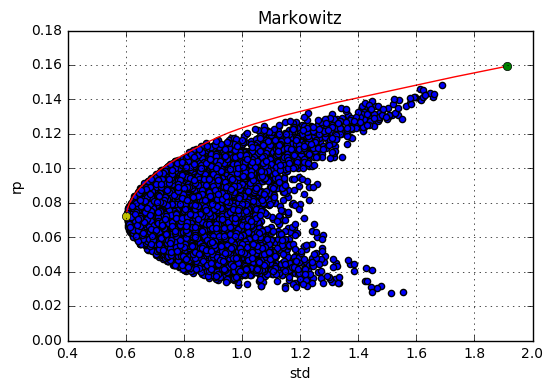

In [35]:
# Plot 


# all portfolios 
portfolios.plot(kind='scatter',x='std',y='rp',grid=True)

# efficient portfolio frontier
plt.plot(port_opt[1],port_opt[0],'r-')

# more risk and returns 
plt.plot(port_opt[1].iloc[0],port_opt[0].iloc[0],'go')

# least risk and returns 
plt.plot(port_opt[1].iloc[-1],port_opt[0].iloc[-1],'yo')

# aesthetics... 
plt.title('Markowitz')
plt.show()

In [49]:
port_opt.iloc[-1]

0    0.072508
1    0.602603
Name: 499, dtype: float64

In [78]:
# Select final portfolio 

w_opt = np.asarray(w_opt_list[0]).reshape(-1)
pd.DataFrame(100*w_opt)

,0
0,99.985617
1,0.000552
2,0.012605
3,0.001040
4,0.000185


## Trade in App

In [79]:
initial_cash = 2000000 - 10000

In [83]:
cash = []
nstocks = []
for w,n in zip(w_opt,list(returns.columns)):
    
    p = prices[n].iloc[-1]
    cash.append(initial_cash*w)
    nstocks.append(int(cash[-1]/p))
    
    print('\nName: {}\n>> Weight: {:0.4f}%\n>> Stocks: {} '.format(n,100*w,nstocks[-1]))


Name: GMEXICO.B
>> Weight: 99.9856%
>> Stocks: 33576 

Name: GRUMA.B
>> Weight: 0.0006%
>> Stocks: 0 

Name: ICH.B
>> Weight: 0.0126%
>> Stocks: 3 

Name: IENOVA
>> Weight: 0.0010%
>> Stocks: 0 

Name: TLEVISA.CPO
>> Weight: 0.0002%
>> Stocks: 0 


In [51]:
# Open the trading session 
ts = TradingSession(user='xd8877',pw='Mexico0r',alias='StaticMarkowitz')
time.sleep(5)

In [93]:
def recursiveOperation(w,s):
    try:
        ts.performOperation(nature='compra',stock='{}'.format(w),number=int(s),price='mercado')
        return 1
    except:
        time.sleep(1)
        return recursiveOperation(w,s)

In [94]:
_id = 0
recorded = []
for w,s in zip(list(returns.columns),nstocks):
    
    if s == 0:
        continue
    
    print('\nInvesting in: {}'.format(w))
    # fill and submit
    try: 
        ts.performOperation(nature='compra',stock='{}'.format(w),number=int(s),price='mercado')
    except:
        print('>> Entering recursive download.')
        recursiveOperation(w,s)
    
    # take screenshow
    file_name = '{}_{}_{}'.format(dt.datetime.strftime(dt.datetime.today(),'%Y%m%d_%Hh%Mm%Ss'),w,_id)
    file_path = '/screenshots/{}.png'.format(file_name)
    ts.browser.get_screenshot_as_file(file_path)
    ts.browser.save_screenshot(file_path)
    _id += 1
    
    # accept
    time.sleep(4)
    try:
        ts.browser.find_element_by_xpath('//a[@id="btn-aceptar"]').click()
    except:
        continue
        
    recorded.append((w,s))
    print('Done!')


Investing in: GMEXICO.B
Done!

Investing in: ICH.B
Done!


In [11]:
#ts = TradingSession(user='sd8892',pw='Mexico0r',alias='Trading Session')
#time.sleep(5)

In [ ]:
for w,s in zip(list(returns.columns),nstocks):
    if w in [i[0] for i in recorded]:
        continue
        
    print('\nInvesting in: {}'.format(w))
    # fill and submit
    try: 
        ts.performOperation(nature='compra',stock='{}'.format(w),number=int(s),price='mercado')
    except:
        print('>> Entering recursive download.')
        recursiveOperation(w,s)
    
    # take screenshow
    file_name = '{}_{}_{}'.format(dt.datetime.strftime(dt.datetime.today(),'%Y%m%d_%Hh%Mm%Ss'),w,_id)
    file_path = '/screenshots/{}.png'.format(file_name)
    ts.browser.get_screenshot_as_file(file_path)
    ts.browser.save_screenshot(file_path)
    _id += 1
    
    # accept
    time.sleep(4)
    try:
        ts.browser.find_element_by_xpath('//a[@id="btn-aceptar"]').click()
    except:
        continue
        
    recorded.append((w,s))
    print('Done!')

In [96]:
ts.close()

In [95]:
list(zip(list(returns.columns),nstocks))

[('GMEXICO.B', 33576),
 ('GRUMA.B', 0),
 ('ICH.B', 3),
 ('IENOVA', 0),
 ('TLEVISA.CPO', 0)]

## Save portfolio value

In [13]:
value = ts.browser.find_element_by_xpath('//span[@class="float_right"]').text

In [14]:
date = dt.datetime.strftime(dt.datetime.now(),'%Y/%m/%d')

In [15]:
np.save('marko_value.npy',{1:{'date':date,'value':value}})

In [16]:
np.load('marko_value.npy').item()

{1: {'date': '2017/03/15', 'value': '$ 2,030,345.62'}}

In [17]:
value

'$ 2,030,345.62'

In [18]:
date

'2017/03/15'

## Value 

In [45]:
% matplotlib inline
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt

In [7]:
log = np.load('marko_value.npy').item()

In [8]:
date = []
val  = []
for k in log:
    date.append(log[k]['date'])
    val.append(log[k]['value'])

In [40]:
def str2float(string):
    return np.float(''.join([i for i in string.strip('$').strip(' ') if i != ',']))

def str2date(string):
    return dt.datetime.strptime(string,'%Y/%m/%d')

In [53]:
df = pd.DataFrame({'Date':list(map(str2date,['2017/03/14']+date)),'Value':list(map(str2float,['2000000']+val))})
df

,Date,Value
0,2017-03-14,2000000.00
1,2017-03-15,2030345.62
2,2017-03-16,2003171.50
3,2017-03-20,2007188.38
4,2017-03-20,2007188.38
5,2017-03-22,2022969.38


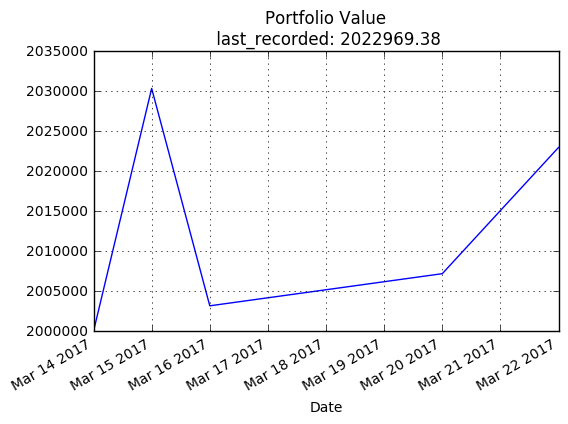

In [54]:
df.plot(x='Date',y='Value',legend=False)
plt.grid(True)
plt.title('Portfolio Value\n last_recorded: {}'.format(df.Value.iloc[-1]))